In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random, gc, keras, os, pickle

from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, MaxPooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16

%matplotlib inline

Using TensorFlow backend.


# Load Data

In [2]:
train_df = pd.read_csv('./data/triplet/train.csv')
val_df = pd.read_csv('./data/triplet/validation.csv')
test_df = pd.read_csv('./data/triplet/test.csv')

print('Train:\t\t', train_df.shape)
print('Validation:\t', val_df.shape)
print('Test:\t\t', test_df.shape)

print('\nTrain Landmarks:\t', len(train_df['landmark_id'].unique()))
print('Validation Landmarks:\t', len(val_df['landmark_id'].unique()))
print('Test Landmarks:\t\t', len(test_df['landmark_id'].unique()))

Train:		 (113783, 4)
Validation:	 (22255, 4)
Test:		 (22391, 4)

Train Landmarks:	 14943
Validation Landmarks:	 7674
Test Landmarks:		 14436


In [3]:
train_df.head()

,image_id,id,url,landmark_id
0,465272,a2ccf8ed2e969f6a,https://lh4.googleusercontent.com/-TPHkS5gzvm4...,0
1,64516,e205ca7c8dd7c027,https://lh3.googleusercontent.com/-V3RjsZtGpxE...,0
2,928409,4e8ab93c1620e8a3,http://mw2.google.com/mw-panoramio/photos/medi...,0
3,88809,896bf928214d1ca4,http://lh5.ggpht.com/-Cy0l41uUaGA/R--yB8vy41I/...,0
4,1001133,375d2a153bdca926,http://lh6.ggpht.com/-UqzFpnqE9bU/S_0u1RovfdI/...,0


# Helper Functions

In [4]:
# training set triplet generator
def train_triplet_generator(df, batch_size=74, img_size=(224, 224), seed=42, 
                            prefix='./data/triplet/train/'):
    """ training set triplet generator
        it will generate 7400 triplet images in total
    """
    # get images with only one training image landmark id and the rest landmark ids
    np.random.seed(seed)
    grouped = df[['landmark_id', 'image_id']].groupby('landmark_id').count().reset_index()
    unique_neg_ids = list(grouped[grouped['image_id'] == 1]['landmark_id'].values)
    rest_ids = list(grouped[grouped['image_id'] > 1]['landmark_id'].values)
    size = 7400 * 2 - len(unique_neg_ids) 
    zeros = np.zeros((batch_size, 3, 1), dtype=K.floatx())
    
    while True:
        # get positive and negative image landmark ids
        np.random.shuffle(rest_ids)
        candidate_ids = list(np.random.choice(rest_ids, size=size, replace=False))
        pos_landmark_ids = candidate_ids[:7400]
        neg_landmark_ids = candidate_ids[7400:] + unique_neg_ids
        np.random.shuffle(neg_landmark_ids)
        
        # transform landmark id into image id
        anc_img_ids = []
        pos_img_ids = []
        neg_img_ids = []
        
        for i in range(len(pos_landmark_ids)):
            tmp_pos_ids = df[df['landmark_id'] == pos_landmark_ids[i]]['image_id'].values
            anc_img_ids.append(tmp_pos_ids[0])
            pos_img_ids.append(tmp_pos_ids[1])
            
            tmp_neg_ids = df[df['landmark_id'] == neg_landmark_ids[i]]['image_id'].values
            neg_img_ids.append(tmp_neg_ids[0])
        
        # iterator to read batch images
        for j in range(len(pos_img_ids) // batch_size):
            batch_anc_img_ids = anc_img_ids[j * batch_size: (j + 1) * batch_size]
            batch_pos_img_ids = pos_img_ids[j * batch_size: (j + 1) * batch_size]
            batch_neg_img_ids = neg_img_ids[j * batch_size: (j + 1) * batch_size]
            
            # get images
            anc_imgs = []
            pos_imgs = []
            neg_imgs = []
            
            # iteratively read images
            for k in range(batch_size):
                anc_path = prefix + str(batch_anc_img_ids[k]) + '.jpg'
                pos_path = prefix + str(batch_pos_img_ids[k]) + '.jpg'
                neg_path = prefix + str(batch_neg_img_ids[k]) + '.jpg'
                
                tmp_anc_img = load_img(anc_path, target_size=img_size)
                tmp_anc_img = img_to_array(tmp_anc_img)
                anc_imgs.append(tmp_anc_img)
                
                tmp_pos_img = load_img(pos_path, target_size=img_size)
                tmp_pos_img = img_to_array(tmp_pos_img)
                pos_imgs.append(tmp_pos_img)
                
                tmp_neg_img = load_img(neg_path, target_size=img_size)
                tmp_neg_img = img_to_array(tmp_neg_img)
                neg_imgs.append(tmp_neg_img)
        
            # transform list to array
            anc_imgs = np.array(anc_imgs, dtype=K.floatx()) / 255.0
            pos_imgs = np.array(pos_imgs, dtype=K.floatx()) / 255.0
            neg_imgs = np.array(neg_imgs, dtype=K.floatx()) / 255.0

            yield [anc_imgs, pos_imgs, neg_imgs], zeros

In [5]:
# validation set triplet generator
def val_triplet_generator(df, batch_size=128, img_size=(224, 224), 
                          seed=42, prefix='./data/triplet/validation'):
    """ validation set triplet collector """
    
     # get images with only one image landmark id and the rest landmark ids
    grouped = df[['landmark_id', 'image_id']].groupby('landmark_id').count().reset_index()
    unique_neg_ids = list(grouped[grouped['image_id'] == 1]['landmark_id'].values)
    rest_ids = list(grouped[grouped['image_id'] > 1]['landmark_id'].values)
    size = 3072 * 2 - len(unique_neg_ids) 
    zeros = np.zeros((batch_size, 3, 1), dtype=K.floatx())
    
    while True:
        # get positive and negative image landmark ids
        np.random.seed(seed)
        candidate_ids = list(np.random.choice(rest_ids, size=size, replace=False))
        pos_landmark_ids = candidate_ids[:3072]
        neg_landmark_ids = candidate_ids[3072:] + unique_neg_ids
        np.random.shuffle(neg_landmark_ids)
        
        # transform landmark id into image id
        anc_img_ids = []
        pos_img_ids = []
        neg_img_ids = []
        
        for i in range(len(pos_landmark_ids)):
            tmp_pos_ids = df[df['landmark_id'] == pos_landmark_ids[i]]['image_id'].values
            anc_img_ids.append(tmp_pos_ids[0])
            pos_img_ids.append(tmp_pos_ids[1])
            
            tmp_neg_ids = df[df['landmark_id'] == neg_landmark_ids[i]]['image_id'].values
            neg_img_ids.append(tmp_neg_ids[0])
        
        # iterator to read batch images
        for j in range(len(pos_img_ids) // batch_size):
            batch_anc_img_ids = anc_img_ids[j * batch_size: (j + 1) * batch_size]
            batch_pos_img_ids = pos_img_ids[j * batch_size: (j + 1) * batch_size]
            batch_neg_img_ids = neg_img_ids[j * batch_size: (j + 1) * batch_size]
            
            # get images
            anc_imgs = []
            pos_imgs = []
            neg_imgs = []
            
            # iteratively read images
            for k in range(batch_size):
                anc_path = prefix + str(batch_anc_img_ids[k]) + '.jpg'
                pos_path = prefix + str(batch_pos_img_ids[k]) + '.jpg'
                neg_path = prefix + str(batch_neg_img_ids[k]) + '.jpg'
                
                tmp_anc_img = load_img(anc_path, target_size=img_size)
                tmp_anc_img = img_to_array(tmp_anc_img)
                anc_imgs.append(tmp_anc_img)
                
                tmp_pos_img = load_img(pos_path, target_size=img_size)
                tmp_pos_img = img_to_array(tmp_pos_img)
                pos_imgs.append(tmp_pos_img)
                
                tmp_neg_img = load_img(neg_path, target_size=img_size)
                tmp_neg_img = img_to_array(tmp_neg_img)
                neg_imgs.append(tmp_neg_img)
        
            # transform list to array
            anc_imgs = np.array(anc_imgs, dtype=K.floatx()) / 255.0
            pos_imgs = np.array(pos_imgs, dtype=K.floatx()) / 255.0
            neg_imgs = np.array(neg_imgs, dtype=K.floatx()) / 255.0
            
            yield [anc_imgs, pos_imgs, neg_imgs], zeros

# Define Triplet Loss Model

In [6]:
# Define base network for triplet network
def base_net(input_shape=(224, 224, 3)):
    """ define triplet network """
    # load pre-trained VGG16 model
    vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    
    # frozen shallow layers
    vgg16.trainable = True
    
    set_trainable = False
    for layer in vgg16.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    
    # define sequential model
    model = Sequential(name='base_net')
    model.add(vgg16)
    model.add(Lambda(lambda x: K.l2_normalize(x, axis=1), name='l2_norm'))
    
    return model

In [7]:
# Define triplet network
def triplet_net(base_model, input_shape=(224, 224, 3)):
    """ function to define triplet networks """
    # define input: anchor, positive, negative
    anchor = Input(shape=input_shape, name='anchor_input')
    positive = Input(shape=input_shape, name='positive_input')
    negative = Input(shape=input_shape, name='negative_input')
    
    # extract vector represent using CNN based model
    anc_vec = base_model(anchor)
    pos_vec = base_model(positive)
    neg_vec = base_model(negative)
    
    # stack outputs
    stacks = Lambda(lambda x: K.stack(x, axis=1), name='output')([anc_vec, pos_vec, neg_vec])

    # define inputs and outputs
    inputs=[anchor, positive, negative]
    outputs = stacks
    
    # define the triplet model
    model = Model(inputs=inputs, outputs=outputs, name='triplet_net')
    
    return model

In [8]:
# Define triplet loss
def triplet_loss(y_true, y_pred):
    """ function to compute triplet loss
        margin is predefined coded, manually change if needed
    """
    # define triplet margin
    margin = K.constant(0.3)
    zero = K.constant(0.0)
    
    # get the prediction vector
    anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    
    # compute distance
    pos_distance = K.sum(K.square(anchor - positive), axis=1)
    neg_distance = K.sum(K.square(anchor - negative), axis=1)
    
    # compute loss
    partial_loss = pos_distance - neg_distance + margin
    full_loss = K.sum(K.maximum(partial_loss, zero), axis=0)
    
    return full_loss

# Build Triplet Model

In [9]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define Parameters
img_size = (224, 224, 3)  # target image size

# triplet image generator
train_generator = train_triplet_generator(train_df, batch_size=74, img_size=img_size[:2], 
                                          seed=42, prefix='./data/triplet/train/')

val_generator = val_triplet_generator(val_df, batch_size=64, img_size=img_size[:2], 
                                      seed=42, prefix='./data/triplet/validation/')

In [10]:
# Define triplet network model
base_model = base_net(input_shape=img_size)
base_model.summary()

Instructions for updating:
dim is deprecated, use axis instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
l2_norm (Lambda)             (None, 512)               0         
Total params: 14,714,688
Trainable params: 7,079,424
Non-trainable params: 7,635,264
_________________________________________________________________


In [11]:
triplet_model = triplet_net(base_model=base_model, input_shape=img_size)
triplet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
base_net (Sequential)           (None, 512)          14714688    anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

# Fit Triplet Model

In [13]:
# define learning scheduler
def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 80:
        lr *= 2e-1
    elif epoch > 60:
        lr *= 4e-1
    elif epoch > 40:
        lr *= 6e-1
    elif epoch > 20:
        lr *= 8e-1
    print('Learning rate: ', lr)
    return lr

# define optimizer
opt = keras.optimizers.Adam(lr=lr_schedule(0))

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/vgg16-triplet(5)-ckpt.h5', 
                             monitor='val_loss', save_best_only=True)
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# compile the model
triplet_model.compile(optimizer=opt, loss=triplet_loss)

Learning rate:  0.001


In [14]:
# fit the mode
history = triplet_model.fit_generator(train_generator, steps_per_epoch=100, epochs=100, 
                                      validation_data=val_generator, validation_steps=48, 
                                      verbose=2, callbacks=callbacks)

triplet_model.save('./models/vgg16-triplet(5)-model.h5')
base_model.save('./models/vgg16-base(5)-model.h5')
pickle.dump(history.history, open('./models/vgg16-triplet(5)-history.p', 'wb'))
_ = gc.collect()

Epoch 1/100
Learning rate:  0.001
 - 77s - loss: 9.4023 - val_loss: 6.7444
Epoch 2/100
Learning rate:  0.001
 - 59s - loss: 6.4922 - val_loss: 6.5809
Epoch 3/100
Learning rate:  0.001
 - 59s - loss: 5.4859 - val_loss: 6.0684
Epoch 4/100
Learning rate:  0.001
 - 60s - loss: 5.4311 - val_loss: 5.2151
Epoch 5/100
Learning rate:  0.001
 - 59s - loss: 4.6238 - val_loss: 4.8134
Epoch 6/100
Learning rate:  0.001
 - 59s - loss: 4.3331 - val_loss: 4.7112
Epoch 7/100
Learning rate:  0.001
 - 58s - loss: 4.0028 - val_loss: 4.3701
Epoch 8/100
Learning rate:  0.001
 - 59s - loss: 3.9773 - val_loss: 4.2999
Epoch 9/100
Learning rate:  0.001
 - 59s - loss: 3.6390 - val_loss: 4.0068
Epoch 10/100
Learning rate:  0.001
 - 60s - loss: 3.3672 - val_loss: 4.1872
Epoch 11/100
Learning rate:  0.001
 - 59s - loss: 3.3661 - val_loss: 3.9370
Epoch 12/100
Learning rate:  0.001
 - 60s - loss: 3.1391 - val_loss: 3.6850
Epoch 13/100
Learning rate:  0.001
 - 59s - loss: 2.9005 - val_loss: 3.6018
Epoch 14/100
Learning

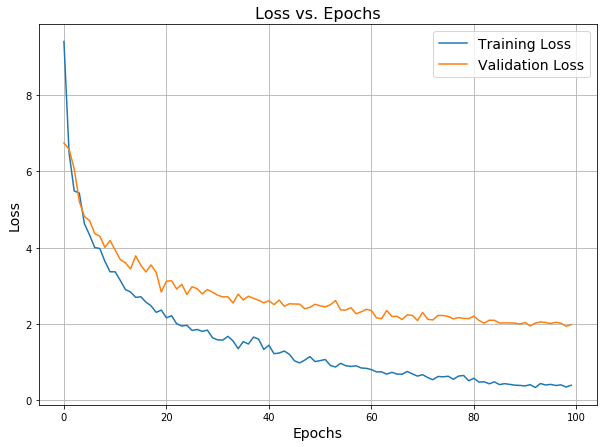

In [15]:
# Visualize the training process
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(train_loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')
ax.set_title('Loss vs. Epochs', fontsize=16)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(fontsize=14)
ax.grid(True)
plt.show()

# Extract Features using Triplet Network

In [16]:
train_df = pd.read_csv('./data/triplet/train.csv')
val_df = pd.read_csv('./data/triplet/validation.csv')
test_df = pd.read_csv('./data/triplet/test.csv')

print('Train:\t\t', train_df.shape)
print('Validation:\t', val_df.shape)
print('Test:\t\t', test_df.shape)

print('\nTrain Landmarks:\t', len(train_df['landmark_id'].unique()))
print('Validation Landmarks:\t', len(val_df['landmark_id'].unique()))
print('Test Landmarks:\t\t', len(test_df['landmark_id'].unique()))

Train:		 (113783, 4)
Validation:	 (22255, 4)
Test:		 (22391, 4)

Train Landmarks:	 14943
Validation Landmarks:	 7674
Test Landmarks:		 14436


In [17]:
# Load trained model
base_model = load_model('./models/vgg16-base(5)-model.h5')
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
l2_norm (Lambda)             (None, 512)               0         
Total params: 14,714,688
Trainable params: 7,079,424
Non-trainable params: 7,635,264
_________________________________________________________________


In [18]:
# Define train_imgs and test_imgs
train_imgs = np.zeros(shape=(len(train_df), 512), dtype=np.float32)
val_imgs = np.zeros(shape=(len(val_df), 512), dtype=np.float32)
test_imgs = np.zeros(shape=(len(test_df), 512), dtype=np.float32)

In [19]:
# Process training images
img_ids = train_df['image_id'].values
steps = 20000
for i in range(0, len(train_df), steps):
    tmp_imgs = []
    print('\nProcess: {:10d}'.format(i))
    
    start = i
    end = min(len(train_df), i + steps)
    for idx in range(start, end):
        if idx % 250 == 0:
            print('=', end='')
            
        img_id = img_ids[idx]
        path = './data/triplet/train/' + str(img_id) + '.jpg'
        img = load_img(path, target_size=img_size[:2])
        img = img_to_array(img)
        tmp_imgs.append(img)
        
    tmp_imgs = np.array(tmp_imgs, dtype=np.float32) / 255.0
    tmp_prediction = base_model.predict(tmp_imgs)
    train_imgs[start: end, ] = tmp_prediction
    _ = gc.collect()


Process:          0
Process:      20000
Process:      40000
Process:      60000
Process:      80000
Process:     100000

In [20]:
# Process validation images
img_ids = val_df['image_id'].values
steps = 4000
for i in range(0, len(val_df), steps):
    tmp_imgs = []
    print('\nProcess: {:10d}'.format(i))
    
    start = i
    end = min(len(val_df), i + steps)
    for idx in range(start, end):
        if idx % 50 == 0:
            print('=', end='')
            
        img_id = img_ids[idx]
        path = './data/triplet/validation/' + str(img_id) + '.jpg'
        img = load_img(path, target_size=img_size[:2])
        img = img_to_array(img)
        tmp_imgs.append(img)
        
    tmp_imgs = np.array(tmp_imgs, dtype=np.float32) / 255.0
    tmp_prediction = base_model.predict(tmp_imgs)
    val_imgs[start: end, ] = tmp_prediction
    _ = gc.collect()


Process:          0
Process:       4000
Process:       8000
Process:      12000
Process:      16000
Process:      20000

In [21]:
# Process test images
img_ids = test_df['image_id'].values
steps = 4000
for i in range(0, len(test_df), steps):
    tmp_imgs = []
    print('\nProcess: {:10d}'.format(i))
    
    start = i
    end = min(len(test_df), i + steps)
    for idx in range(start, end):
        if idx % 50 == 0:
            print('=', end='')
            
        img_id = img_ids[idx]
        path = './data/triplet/test/' + str(img_id) + '.jpg'
        img = load_img(path, target_size=img_size[:2])
        img = img_to_array(img)
        tmp_imgs.append(img)
        
    tmp_imgs = np.array(tmp_imgs, dtype=np.float32) / 255.0
    tmp_prediction = base_model.predict(tmp_imgs)
    test_imgs[start: end, ] = tmp_prediction
    _ = gc.collect()


Process:          0
Process:       4000
Process:       8000
Process:      12000
Process:      16000
Process:      20000

In [22]:
print('Train:\t\t', train_imgs.shape)
print('Validation:\t', val_imgs.shape)
print('Test:\t\t', test_imgs.shape)

Train:		 (113783, 512)
Validation:	 (22255, 512)
Test:		 (22391, 512)


In [23]:
# Save to disk
np.save('./data/triplet/train_triplet_vgg16(5)_features.npy', train_imgs)
np.save('./data/triplet/validation_triplet_vgg16(5)_features.npy', val_imgs)
np.save('./data/triplet/test_triplet_vgg16(5)_features.npy', test_imgs)